In [1]:
import numpy as np
from matplotlib.pyplot import *


from skimage.data import *

img_name = 'lenna.jpg'

IMAGE_DIR = "../data/imgs/" + img_name

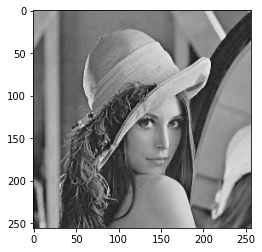

In [2]:
image = imread (IMAGE_DIR)

imshow(image, cmap = "gray")

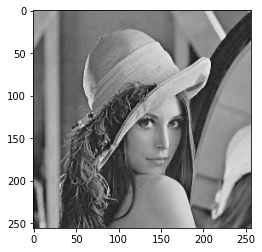

In [3]:
def gnoise (image, sigma = 25) :
    return image + np.random.normal (0,sigma, np.shape (image))


imshow (image, cmap = 'gray')

In [4]:
def neumann_bc (image, border_size = 10) :
    d = border_size
    a, b = np.shape (image)[0], np.shape (image)[1]
        
    A = a + 2 * d
    B = b + 2 * d
    
    I = np.zeros ((A,B))
    
    I [d:(A-d) , d:(B-d)] = image
    
    for i in range (d,A-d) :
        for j in range (0,d) :
            I [i,j] = I [i, 2 * d - j]
            
        for j in range (0,d) :
            I [i,j+B-d] = I [i, B-d-1 - j]
    
    for j in range (0,B) :
        for i in range (0,d) :
            I [i,j] = I [2 * d - i, j]
            
        for i in range (0,d) :
            I [i+B-d,j] = I [B-d-1 - i, j]

    return I

In [5]:
def grad (P) :
    a, b = np.shape (P)[0], np.shape (P)[1]

    Dx = np.zeros ((a,b))
    Dy = np.zeros ((a,b))
    
    for i in range (a) :
        for j in range (b) :
            if i < a-1 :
                Dx [i,j] = P [i+1,j] - P [i,j]
            elif i == a-1 :
                Dx[i,j] = 0

            if j < b-1 :
                Dy [i,j] = P [i,j+1] - P [i,j]
            elif j == b-1 :
                Dy [i,j] = 0
            
    return Dx, Dy

def div (P) :
    a, b = np.shape (P)[1], np.shape (P)[2]

    Dx = np.zeros ((a,b))
    Dy = np.zeros ((a,b))

    
    for i in range (a) :
        for j in range (b) : 
            if 0 < i < a-1 :
                Dx [i,j] = P [0,i,j] - P [0,i-1,j]
            elif i == 0 :
                Dx [i,j] = P [0,i,j]
            elif i == a-1 :
                Dx [i,j] = - P [0,i-1,j]
                
            if 0 < j < a-1 :
                Dy [i,j] = P [1,i,j] - P [1,i,j-1]
            elif j == 0 :
                Dy [i,j] = P [1,i,j]
            elif j == b-1 :
                Dy [i,j] = - P [1,i,j-1]
                
    return Dx + Dy

In [6]:
def hessian (v) :
    a, b = np.shape (v)

    H11 = np.zeros ((a,b))
    H12 = np.zeros ((a,b))
    H21 = np.zeros ((a,b))
    H22 = np.zeros ((a,b))
    
    for i in range (a) :
        for j in range (b) :
            if 0 < i < a-1 :
                H11 [i,j] = v[i+1,j] - 2 * v[i,j] + v[i-1,j]
            elif i == 0 :
                H11 [i,j] = v[i+1,j] - v[i,j]
            elif i == a-1 :
                H11 [i,j] = v[i-1,j] - v[i,j]
    
            if 0 < i <= a-1 and 0 <= j < b-1 :
                H12 [i,j] = v[i,j+1] - v[i,j] + v[i-1,j+1] + v[i-1,j]
            elif i == 0 or i == a-1 :
                H12 [i,j] = 0
            
            if 0 <= i < a-1 and 0 < j <= b-1 :
                H21 [i,j] = v[i+1,j] - v[i,j] + v[i+1,j-1] + v[i,j-1]
            elif i == 0 or i == a-1 :
                H21 [i,j] = 0

            if 0 < j < b-1 :
                H22 [i,j] = v[i,j+1] - 2 * v[i,j] + v[i,j-1]
            elif j == 0 :
                H22 [i,j] = v[i,j+1] - v[i,j]                
            elif j == b-1 :
                H22 [i,j] = v[i,j-1] - v[i,j]
            
    return H11, H12, H21, H22

def hessian_s (p) :
    a, b = np.shape (p)[1], np.shape (p)[2]
    
    H11 = np.zeros ((a,b))
    H12 = np.zeros ((a,b))
    H21 = np.zeros ((a,b))
    H22 = np.zeros ((a,b))
    
    for i in range (a) :
        for j in range (b) :
            if 0 < i < a-1 :
                H11 [i,j] = p[0,i-1,j] - 2 * p[0,i,j] + p[0,i+1,j]
            elif i == 0 :
                H11 [i,j] = p[0,i+1,j] - p[0,i,j]
            elif i == b-1 :
                H11 [i,j] = p[0,i-1,j] - p[0,i,j]
            
            if 0 < j < b-1 :
                H22 [i,j] = p[3,i,j-1] - 2 * p[3,i,j] + p[3,i,j+1]
            elif j == 0 :
                H22 [i,j] = p[3,i,j+1] - p[3,i,j]
            elif j == b-1 :
                H22 [i,j] = p[3,i,j-1] - p[3,i,j]
            
            if 0 < j < b-1 :
                if 0 < i < a-1 :
                    H12 [i,j] = p[1,i,j-1] - p[1,i,j] - p[1,i+1,j-1] + p[1,i+1,j]
                elif i == 0 :
                    H12 [i,j] = p[1,i+1,j] - p[1,i+1,j-1]
                elif i == a-1 :
                    H12 [i,j] = p[1,i,j-1] - p[1,i,j]
            if 0 < i < a-1 :
                if j == 0 :
                    H12 [i,j] = p[1,i+1,j] - p[1,i,j]
                elif j == b-1 :
                    H12 [i,j] = p[1,i,j-1] - p[1,i+1,j-1] 
            if i == 0 :
                if j == 0 :
                    H12 [i,j] = p[1,i+1,j]
                elif j == b-1 :
                    H12 [i,j] = - p[1,i+1,j-1]
            if i == a-1 :
                if j == 0 :
                    H12 [i,j] = - p[1,i,j]
                elif j == b-1 :
                    H12 [i,j] = - p[1,i,j-1]
            
            if 0 < j < b-1 :
                if 0 < i < a-1 :
                    H21 [i,j] = p[2,i-1,j] - p[2,i,j] - p[2,i-1,j+1] + p[2,i,j+1]
                elif i == 0 :
                    H21 [i,j] = p[2,i,j+1] - p[2,i,j]
                elif i == a-1 :
                    H21 [i,j] = p[2,i-1,j] - p[2,i-1,j+1]

            if 0 < i < a-1 :
                if j == 0 :
                    H21 [i,j] = p[2,i,j+1] - p[2,i-1,j+1]
                elif j == b-1 :
                    H21 [i,j] = p[2,i-1,j] - p[2,i,j]
            
            if i == 0 :
                if j == 0 :
                    H21 [i,j] = p[2,i,j+1]
                elif j == b-1 :
                    H21 [i,j] = - p[2,i,j]
                
            if i == a-1 :
                if j == 0 :
                    H21 [i,j] = - p[2,i-1,j+1]
                elif j == b-1 :
                    H21 [i,j] = p[2,i-1,j]

    return H11 + H12 + H22 + H21

In [7]:
def norm (u) :
    return np.sqrt (sum(np.power (u,2)))

def PSNR (ud, u) :
    '''Peak Signal to Noise Ratio'''
    return 20 * np.log10 (np.divide (255, np.absolute (norm(ud-u))))
    
def SNR (ud, u) :
    '''Signal to Noise Ratio'''
    return 20 * np.log10 (np.divide (norm(u), norm(ud-u)))

In [8]:
def chambolle1 (g, L = 50, max_iter = 500, tau = 1/8, eps = 1/100) :
        
    p = np.zeros (np.shape ((g,g)))
    
    for i in range (max_iter) :        

        gd = grad (div(p) - np.divide (g,L))
        
        norm_gd = np.sqrt (sum(np.power (gd,2)))
        
        new_p = np.divide (p + np.dot (tau,gd) , 1 + tau*norm_gd)
        
        if np.max (np.abs (new_p - p)) < eps :
            pass
        
        p = new_p
        
        if not i % 10 :
            print (f'iter {i}')
    return g - L * div (p)

In [9]:
def chambolle2 (g, L = 10, max_iter = 500, tau = 1/8, eps = 1/100) :
        
    p = np.zeros (np.shape ((g,g,g,g)))
    for i in range (max_iter) :

        gd =  hessian(hessian_s(p) - np.divide (g,L))
        
        norm_gd = np.sqrt (sum(np.power (gd,2)))
        
        new_p = np.divide (p - np.dot (tau,gd) , 1 + tau*norm_gd)
        
        if np.max (np.abs (new_p - p)) < eps :
            pass
                
        p = new_p
        
        if not i % 10 :
            print (f'iter {i}')
    return g - L * hessian_s (p)

In [10]:
import time

I = gnoise (image, sigma := 50)

start = time.time()

DI = chambolle1 (g = I)

elapsed = time.time()
elapsed = elapsed - start
print ("Time spent is: ", elapsed)

iter 0
iter 10
iter 20
iter 30
iter 40
iter 50
iter 60
iter 70
iter 80
iter 90
iter 100
iter 110
iter 120
iter 130
iter 140
iter 150
iter 160
iter 170
iter 180
iter 190
iter 200
iter 210
iter 220
iter 230
iter 240
iter 250
iter 260
iter 270
iter 280
iter 290
iter 300
iter 310
iter 320
iter 330
iter 340
iter 350
iter 360
iter 370
iter 380
iter 390
iter 400
iter 410
iter 420
iter 430
iter 440
iter 450
iter 460
iter 470
iter 480
iter 490
Time spent is:  115.78338694572449


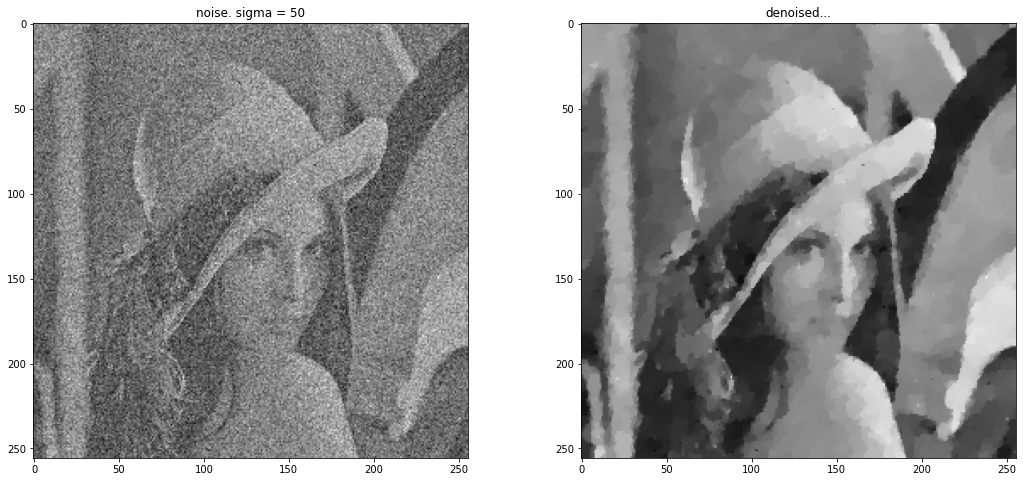

In [11]:
fig = figure(figsize=(18,8))

ax = fig.add_subplot(1, 2, 1)
imshow(I, cmap = 'gray')
ax.set_title(f'noise. sigma = {sigma}')

ax = fig.add_subplot(1, 2, 2)
ax.set_title('denoised...')
imshow(DI, cmap = 'gray')